# Задание

Обучить сиамскую сеть для верификации лиц на датасете LFW

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import time
from PIL import Image
from tqdm import tqdm
import random
%matplotlib inline

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz
!rm lfw.tgz
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

In [ ]:
people = os.listdir('/content/lfw')
pn_pairs = []
for person in people:
  temp = people.copy()
  temp.pop(temp.index(person))
  pn_pairs.append((person, random.choice(temp)))

print(pn_pairs)
assert len(pn_pairs) == len(people)
assert all(x[0] != x[1] for x in pn_pairs)

[('Richard_Fine', 'Cristiano_da_Matta'), ('Michelle_Yeoh', 'Scott_Peterson'), ('Tamara_Mowry', 'Kosuke_Kitajima'), ('Luis_Fonsi', 'Chris_Gratton'), ('Hong_Myung', 'Christine_Baumgartner'), ('Carol_Niedermayer', 'Richard_Hellfant'), ('Johnson_Panjaitan', 'Steve_Nesbitt'), ('Francois_Ozon', 'Herta_Daeubler-Gmelin'), ('Terrence_Trammell', 'Andres_Manuel_Lopez_Obrador'), ('Alastair_Campbell', 'Ignacio_Antonio_Velasco'), ('Sophie', 'Bernard_Law'), ('Michael_Diekmann', 'Wilbert_Foy'), ('Catherine_Woodard', 'Jim_Paxson'), ('Marianne_Stanley', 'Flor_Montulo'), ('Kevin_Stallings', 'Rainer_Schuettler'), ('Mahdi_Al_Bassam', 'Gonzalo_Barrientos'), ('Douglas_Gansler', 'Michelle_Lecky'), ('Peter_Hillary', 'Thalia'), ('Ruben_Studdard', 'Donald_Evans'), ('Scott_Hoch', 'George_Plimpton'), ('Hal_McCoy', 'Terry_Stotts'), ('Ahmet_Necdet_Sezer', 'Estella_Warren'), ('Eve_Ensler', 'Gus_Van_Sant'), ('Barrett_Jackman', 'Michael_Donovan'), ('Michael_Hagee', 'Abdul_Rahman'), ('David_Hasselhoff', 'Vicente_Fox_de_

In [ ]:
image_path = []
for i in os.walk('/content/lfw'):
  for j in i[-1]:
    image_path.append(i[0] + '/' + j)
print(len(image_path))
print(image_path[:5])

13233
['/content/lfw/Richard_Fine/Richard_Fine_0001.jpg', '/content/lfw/Michelle_Yeoh/Michelle_Yeoh_0004.jpg', '/content/lfw/Michelle_Yeoh/Michelle_Yeoh_0005.jpg', '/content/lfw/Michelle_Yeoh/Michelle_Yeoh_0003.jpg', '/content/lfw/Michelle_Yeoh/Michelle_Yeoh_0002.jpg']


In [ ]:
def make_pn_pairs(pairs=pn_pairs, dir='/content/lfw'):
  pn_images = []
  for pair in pairs:
    l = os.listdir(dir+'/'+pair[0]+'/')
    for i in l:
      image = dir+'/'+pair[0]+'/'+i
      positive = dir+'/'+pair[0]+'/'+random.choice(l)
      n = os.listdir(dir+'/'+pair[1]+'/')
      negative = dir+'/'+pair[1]+'/'+random.choice(n)
      pn_images.append((image, positive, negative))

  return pn_images

pn_images = make_pn_pairs()
print(pn_images[0])
assert all(((x[0].split('/')[1] == x[1].split('/')[1]) and (x[1] != x[2])) for x in pn_images)

('/content/lfw/Richard_Fine/Richard_Fine_0001.jpg', '/content/lfw/Richard_Fine/Richard_Fine_0001.jpg', '/content/lfw/Cristiano_da_Matta/Cristiano_da_Matta_0001.jpg')


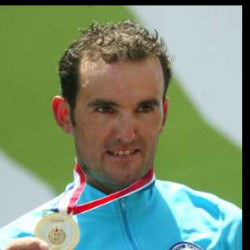

In [ ]:
Image.open(image_path[-1])

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [ ]:
def preprocess_image_pair(image_pair):
  try:
    img1, img2, img3 = tf.io.read_file(image_pair[0]), tf.io.read_file(image_pair[1]), tf.io.read_file(image_pair[2])
    img1, img2, img3 = tf.image.decode_jpeg(img1, channels=3), tf.image.decode_jpeg(img2, channels=3), tf.image.decode_jpeg(img3, channels=3)
    img1, img2, img3 = np.asarray(img1), np.asarray(img2), np.asarray(img3)
    (x1, y1, w1, h1), (x2, y2, w2, h2), (x3, y3, w3, h3) = face_cascade.detectMultiScale(img1, 1.3, 5)[0], face_cascade.detectMultiScale(img2, 1.3, 5)[0], face_cascade.detectMultiScale(img3, 1.3, 5)[0]
    img1 , img2, img3 = img1[y1:y1+h1, x1:x1+w1], img2[y2:y2+h2, x2:x2+w2], img3[y3:y3+h3, x3:x3+w3]
    img1, img2, img3 = tf.image.resize(img1, (299, 299)), tf.image.resize(img2, (299, 299)), tf.image.resize(img3, (299, 299))
    img1, img2, img3 = tf.keras.applications.inception_v3.preprocess_input(img1), tf.keras.applications.inception_v3.preprocess_input(img2), tf.keras.applications.inception_v3.preprocess_input(img3)
    return np.array(img1, ndmin=4), np.array(img2, ndmin=4), np.array(img3, ndmin=4)
  except:
    pass

data = preprocess_image_pair(pn_images[46])
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
class SiameseNet(tf.keras.layers.Layer):

  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, feat):
    feats = self.model(feat[0])
    nfeats = self.model(feat[2])
    pfeats = self.model(feat[1])
    final = tf.stack([feats, pfeats, nfeats])
    return tf.transpose(final, perm=[1,2,0])


class TripletLoss(tf.keras.layers.Layer):

  def __init__(self, alpha):
    self.alpha = alpha
    super().__init__()

  def call(self, features):
    pos = K.sum(K.square(features[:,:,0] - features[:,:,1]))
    neg = K.sum(K.square(features[:,:,0] - features[:,:,2]))
    base_loss = pos - neg + self.alpha
    return K.maximum(base_loss, 0.0)

def identity_loss(y_true, y_pred):
  return K.mean(y_pred)


In [ ]:
image_input = tf.keras.layers.Input(shape=(299,299,3), name='image_input')
negative_input = tf.keras.layers.Input(shape=(299,299,3), name='negative_input')
positive_input = tf.keras.layers.Input(shape=(299,299,3), name='positive_input')

siamese = SiameseNet(image_features_extract_model)([image_input, positive_input, negative_input])
loss = TripletLoss(alpha=1)(siamese)
model = tf.keras.Model(inputs=[image_input, positive_input, negative_input], outputs=loss)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4), loss = identity_loss)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 299, 299, 3  0           []                               
                                )]                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
images, positives, negatives = [], [], []

for pair in tqdm(pn_images[:500]):
  try:
    data = preprocess_image_pair(pair)
    images.append(data[0])
    negatives.append(data[2])
    positives.append(data[1])
  except:
    pass

images = np.concatenate(images)
positives = np.concatenate(positives)
negatives = np.concatenate(negatives)

100%|██████████| 500/500 [00:24<00:00, 20.44it/s]


In [ ]:
images.shape

(366, 299, 299, 3)

In [ ]:
def scheduler(epoch, lr):     # Reduces LR by a factor of 10 on each epoch
  if epoch == 1:
    return lr
  return lr / 10

callbacks = [
  tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
]

In [ ]:
history = model.fit([images, positives, negatives], np.ones(images.shape[0]), batch_size=10, verbose=2, epochs=6, callbacks=callbacks)

Epoch 1/6
37/37 - 48s - loss: 0.8221 - lr: 1.0000e-05 - 48s/epoch - 1s/step
Epoch 2/6
37/37 - 15s - loss: 0.3237 - lr: 1.0000e-05 - 15s/epoch - 412ms/step
Epoch 3/6
37/37 - 15s - loss: 0.1740 - lr: 1.0000e-06 - 15s/epoch - 410ms/step
Epoch 4/6
37/37 - 15s - loss: 0.1090 - lr: 1.0000e-07 - 15s/epoch - 412ms/step
Epoch 5/6
37/37 - 15s - loss: 0.1697 - lr: 1.0000e-08 - 15s/epoch - 418ms/step
Epoch 6/6
37/37 - 16s - loss: 0.1050 - lr: 1.0000e-09 - 16s/epoch - 419ms/step


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'lr'])


Text(0.5, 1.0, 'Loss')

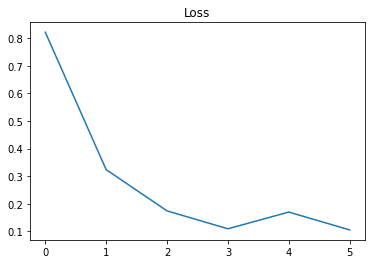

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss')

Text(0.5, 1.0, 'Learning Rate')

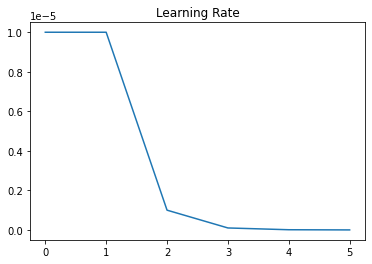

In [ ]:
plt.plot(history.history['lr'])
plt.title('Learning Rate')